<a href="https://colab.research.google.com/github/naphatsiri/M.Sc-IS-Fault-Detection/blob/main/IS_fault_detection_06102568.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.Data preparation

In [18]:
#Import working libraries.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
!wget https://github.com/naphatsiri/M.Sc-IS-Fault-Detection/raw/main/Refrigerant-leak_data/normal%20r.xls
!wget https://github.com/naphatsiri/M.Sc-IS-Fault-Detection/raw/main/Refrigerant-leak_data/rl10.xls

--2025-10-06 08:56:23--  https://github.com/naphatsiri/M.Sc-IS-Fault-Detection/raw/main/Refrigerant-leak_data/normal%20r.xls
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/naphatsiri/M.Sc-IS-Fault-Detection/main/Refrigerant-leak_data/normal%20r.xls [following]
--2025-10-06 08:56:24--  https://raw.githubusercontent.com/naphatsiri/M.Sc-IS-Fault-Detection/main/Refrigerant-leak_data/normal%20r.xls
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3102208 (3.0M) [application/octet-stream]
Saving to: ‘normal r.xls’

normal r.xls        100%[===================>]   2.96M  --.-KB/s    in 0.06s   

2025-1

In [30]:
#Use rl10% and rl_normal dataset

df_normal = pd.read_excel("/content/normal r.xls", sheet_name="Reduced Data Set", engine='xlrd')
df_fault = pd.read_excel("/content/rl10.xls", sheet_name="Reduced Data Set", engine='xlrd')

In [25]:
df_normal.info()
df_fault.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433 entries, 0 to 432
Data columns (total 66 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Time (minutes)       433 non-null    float64
 1   TWE_set              433 non-null    int64  
 2   TEI                  433 non-null    float64
 3   TWEI                 433 non-null    float64
 4   TEO                  433 non-null    float64
 5   TWEO                 433 non-null    float64
 6   TCI                  433 non-null    float64
 7   TWCI                 433 non-null    float64
 8   TCO                  433 non-null    float64
 9   TWCO                 433 non-null    float64
 10  TSI                  433 non-null    float64
 11  TSO                  433 non-null    float64
 12  TBI                  433 non-null    float64
 13  TBO                  433 non-null    float64
 14  Cond Tons            433 non-null    float64
 15  Cooling Tons         433 non-null    flo

In [31]:
df_normal["label"] = 0
df_fault["label"] = 1

df = pd.concat([df_normal, df_fault], ignore_index=True)

In [32]:
df.shape

(866, 67)

In [33]:
#Clean and filter the data : removen oise, non-operational periods, and impossible values.

# Keep only rows where the unit is operating
# what is unit status ?

'''df = df[df["Unit Status"] == 1]'''

# Only remove *obviously invalid* rows
df = df[(df["Cooling Tons"] >= 0) & (df["kW"] >= 0)]

# Clip outliers (not drop)
for col in ["PRE", "PRC", "kW", "Cooling Tons", "COP", "Amps"]:
    lower, upper = df[col].quantile([0.001, 0.999])
    df[col] = df[col].clip(lower, upper)

print("Cleaned data shape:", df.shape)



Cleaned data shape: (866, 67)


In [35]:
df.head()

,Time (minutes),TWE_set,TEI,TWEI,TEO,TWEO,TCI,TWCI,TCO,TWCO,...,VE,VW,TWI,TWO,THI,THO,FWW,FWH,FWB,label
0,0.0612,50,65.59,65.6,66.40,66.4,67.44,67.3,68.50,68.4,...,56,0.0,66.21,71.01,67.54,70.72,2.202000e-47,5.491000e-46,3.853000e-45,0
1,2.0600,50,67.23,67.6,67.26,67.3,67.56,67.3,67.76,67.3,...,56,30.0,63.67,66.35,67.83,67.73,1.527000e+01,5.041000e+01,2.698000e+02,0
2,4.0600,50,67.64,67.8,67.59,67.5,67.31,67.0,67.47,67.3,...,56,30.0,62.03,65.49,67.91,67.81,2.146000e+01,2.438000e+01,2.693000e+02,0
3,6.0600,50,67.44,67.3,67.42,67.3,66.86,66.5,67.07,66.7,...,56,30.0,59.74,63.89,67.70,67.60,2.589000e+01,2.442000e+01,2.603000e+02,0
4,8.0600,49,66.66,66.2,64.92,63.7,67.76,68.4,69.89,71.4,...,56,20.0,59.17,64.75,66.80,66.79,5.489000e+01,2.461000e+01,-8.491000e+01,0


In [36]:
# Select the relevant columns for ML

# Core measured features for refrigerant leak detection
selected_features = [
    "TEI", "TEO", "TWI", "TWO",           # Thermal temperatures
    "TCI", "TCO", "TWCI", "TWCO",         # Condenser temps
    "PRE", "PRC", "P_lift",               # Pressure features
    "kW", "COP", "Cooling Tons",          # Performance indicators
    "Amps", "RLA%",                       # Electrical features
    "Tsh_suc", "Tsh_dis",                 # Superheat
    "kW/Ton"                              # Efficiency
]

df = df[["Time (minutes)"] + selected_features + ["label"]]
print("Final feature set:", df.shape)


Final feature set: (866, 21)


In [37]:
df.head()

,Time (minutes),TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,P_lift,kW,COP,Cooling Tons,Amps,RLA%,Tsh_suc,Tsh_dis,kW/Ton,label
0,0.0612,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1,...,0.0,1.682000e-45,3.649000e-46,2.722816e-47,0,0,16.1,6.4,1.682000e-45,0
1,2.0600,67.23,67.26,63.67,66.35,67.56,67.76,67.3,67.3,67.5,...,0.0,1.682000e-45,8.203000e-01,1.701000e+00,0,0,16.4,5.7,1.682000e-45,0
2,4.0600,67.64,67.59,62.03,65.49,67.31,67.47,67.0,67.3,67.0,...,0.0,1.682000e-45,1.764000e+00,3.087000e+00,0,0,15.3,6.0,1.682000e-45,0
3,6.0600,67.44,67.42,59.74,63.89,66.86,67.07,66.5,66.7,66.7,...,0.0,1.682000e-45,4.665000e-01,4.474000e+00,0,0,13.3,7.3,1.682000e-45,0
4,8.0600,66.66,64.92,59.17,64.75,67.76,69.89,68.4,71.4,55.7,...,18.7,3.601000e+01,1.539000e+00,1.276000e+01,43,41,7.1,33.6,2.284000e+00,0


In [ ]:
#To confirm that there is no missing value.

print(df.isna().sum())

Time (minutes)    0
TEI               0
TEO               0
TWI               0
TWO               0
TCI               0
TCO               0
TWCI              0
TWCO              0
PRE               0
PRC               0
P_lift            0
kW                0
COP               0
Cooling Tons      0
Amps              0
RLA%              0
Tsh_suc           0
Tsh_dis           0
kW/Ton            0
label             0
dtype: int64


## 2.Features engineering operation

In [38]:
# Derived temperature features

# Evaporator and condenser approach temperatures
df["Evap_Approach"] = df["TEO"] - df["TEI"]        # Evaporator approach (ΔT across evaporator)
df["Cond_Approach"] = df["TCO"] - df["TCI"]        # Condenser approach (ΔT across condenser)

# Temperature lift: overall temperature difference between condenser and evaporator
df["Temp_Lift"] = df["TCO"] - df["TEO"]

# Pressure-based features
df["Pressure_Ratio"] = df["PRC"] / df["PRE"].replace(0, np.nan)  # Prevent divide-by-zero

# Efficiency-based features
df["kW_per_Ton"] = df["kW"] / df["Cooling Tons"].replace(0, np.nan)

# Superheat difference
df["Delta_Superheat"] = df["Tsh_suc"] - df["Tsh_dis"]


In [39]:
df.head()

,Time (minutes),TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,Tsh_suc,Tsh_dis,kW/Ton,label,Evap_Approach,Cond_Approach,Temp_Lift,Pressure_Ratio,kW_per_Ton,Delta_Superheat
0,0.0612,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1,...,16.1,6.4,1.682000e-45,0,0.81,1.06,2.10,0.998487,6.177428e+01,9.7
1,2.0600,67.23,67.26,63.67,66.35,67.56,67.76,67.3,67.3,67.5,...,16.4,5.7,1.682000e-45,0,0.03,0.20,0.50,1.000000,9.888301e-46,10.7
2,4.0600,67.64,67.59,62.03,65.49,67.31,67.47,67.0,67.3,67.0,...,15.3,6.0,1.682000e-45,0,-0.05,0.16,-0.12,1.000000,5.448656e-46,9.3
3,6.0600,67.44,67.42,59.74,63.89,66.86,67.07,66.5,66.7,66.7,...,13.3,7.3,1.682000e-45,0,-0.02,0.21,-0.35,0.989505,3.759499e-46,6.0
4,8.0600,66.66,64.92,59.17,64.75,67.76,69.89,68.4,71.4,55.7,...,7.1,33.6,2.284000e+00,0,-1.74,2.13,4.97,1.346499,2.822100e+00,-26.5


In [41]:
# Create Rolling (Time-Series) Features

# Define columns to create rolling stats for
rolling_cols = ["COP", "kW", "Cooling Tons", "PRE", "PRC"]

# Create rolling mean and standard deviation (window ~6 samples ≈ 1 min)
for col in rolling_cols:
    df[f"{col}_mean"] = df[col].rolling(window=6, min_periods=1).mean()
    df[f"{col}_std"] = df[col].rolling(window=6, min_periods=1).std()


In [42]:
df.head()

,Time (minutes),TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,COP_mean,COP_std,kW_mean,kW_std,Cooling Tons_mean,Cooling Tons_std,PRE_mean,PRE_std,PRC_mean,PRC_std
0,0.0612,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1,...,3.649000e-46,NaN,1.682000e-45,NaN,2.722816e-47,NaN,66.100000,NaN,66.000000,NaN
1,2.0600,67.23,67.26,63.67,66.35,67.56,67.76,67.3,67.3,67.5,...,4.101500e-01,0.580040,1.682000e-45,0.000000,8.505000e-01,1.202789,66.800000,0.989949,66.750000,1.060660
2,4.0600,67.64,67.59,62.03,65.49,67.31,67.47,67.0,67.3,67.0,...,8.614333e-01,0.882719,1.682000e-45,0.000000,1.596000e+00,1.546176,66.866667,0.709460,66.833333,0.763763
3,6.0600,67.44,67.42,59.74,63.89,66.86,67.07,66.5,66.7,66.7,...,7.627000e-01,0.747299,1.682000e-45,0.000000,2.315500e+00,1.914287,66.825000,0.585235,66.625000,0.750000
4,8.0600,66.66,64.92,59.17,64.75,67.76,69.89,68.4,71.4,55.7,...,9.179600e-01,0.734418,7.202000e+00,16.104162,4.404400e+00,4.956399,64.600000,5.001000,68.300000,3.801316


In [43]:
df.shape

(866, 37)

In [44]:
# Final features of operational data.

feature_cols = [
    # Raw sensor features
    "TEI", "TEO", "TWI", "TWO", "TCI", "TCO",
    "PRE", "PRC", "P_lift", "kW", "COP", "Cooling Tons",
    "Amps", "RLA%", "Tsh_suc", "Tsh_dis", "kW/Ton",

    # Derived features
    "Evap_Approach", "Cond_Approach", "Temp_Lift",
    "Pressure_Ratio", "kW_per_Ton", "Delta_Superheat",

    # Rolling features
    "COP_mean", "COP_std", "kW_mean", "kW_std",
    "PRE_mean", "PRE_std", "PRC_mean", "PRC_std"
]

# Fill missing values safely before dropping
df[feature_cols] = df[feature_cols].replace([np.inf, -np.inf], np.nan)
df[feature_cols] = df[feature_cols].fillna(df[feature_cols].median())

# Drop any NaN rows created by rolling calculations
df = df.dropna(subset=feature_cols)

print("Final feature matrix shape:", df[feature_cols].shape)


Final feature matrix shape: (866, 31)


In [45]:
df.head()

,Time (minutes),TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,COP_mean,COP_std,kW_mean,kW_std,Cooling Tons_mean,Cooling Tons_std,PRE_mean,PRE_std,PRC_mean,PRC_std
0,0.0612,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1,...,3.649000e-46,0.102191,1.682000e-45,1.997395,2.722816e-47,NaN,66.100000,0.348807,66.000000,1.356466
1,2.0600,67.23,67.26,63.67,66.35,67.56,67.76,67.3,67.3,67.5,...,4.101500e-01,0.580040,1.682000e-45,0.000000,8.505000e-01,1.202789,66.800000,0.989949,66.750000,1.060660
2,4.0600,67.64,67.59,62.03,65.49,67.31,67.47,67.0,67.3,67.0,...,8.614333e-01,0.882719,1.682000e-45,0.000000,1.596000e+00,1.546176,66.866667,0.709460,66.833333,0.763763
3,6.0600,67.44,67.42,59.74,63.89,66.86,67.07,66.5,66.7,66.7,...,7.627000e-01,0.747299,1.682000e-45,0.000000,2.315500e+00,1.914287,66.825000,0.585235,66.625000,0.750000
4,8.0600,66.66,64.92,59.17,64.75,67.76,69.89,68.4,71.4,55.7,...,9.179600e-01,0.734418,7.202000e+00,16.104162,4.404400e+00,4.956399,64.600000,5.001000,68.300000,3.801316


In [49]:
print("Label distribution:")
print(df["label"].value_counts())


Label distribution:
label
0    433
1    433
Name: count, dtype: int64


## 3.ML model operation

In [46]:
#Import working libraries.

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier

In [47]:
# Separate features and label
X = df.drop(columns=["Time (minutes)", "label"])
y = df["label"]

# Sandardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [48]:
# Train-Test-Split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (606, 35)
Test size: (260, 35)


In [50]:
# Train the XGBoost Model : Create the XGBoost classifier

model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train the model
model.fit(X_train, y_train)

print("XGBoost model training completed!")


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:30:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost model training completed!


## 4.Evaluation mectrics

In [51]:
#Make prediction and evaluate

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=3))

print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))


Classification Report:
              precision    recall  f1-score   support

           0      0.941     0.955     0.948       133
           1      0.952     0.937     0.944       127

    accuracy                          0.946       260
   macro avg      0.946     0.946     0.946       260
weighted avg      0.946     0.946     0.946       260

ROC-AUC Score: 0.9920667811260435


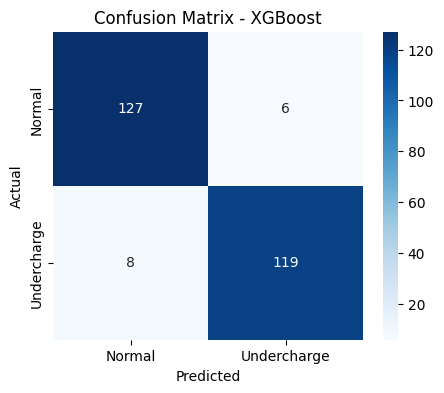

In [52]:
# Confusion matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Undercharge'],
            yticklabels=['Normal', 'Undercharge'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')

plt.show()


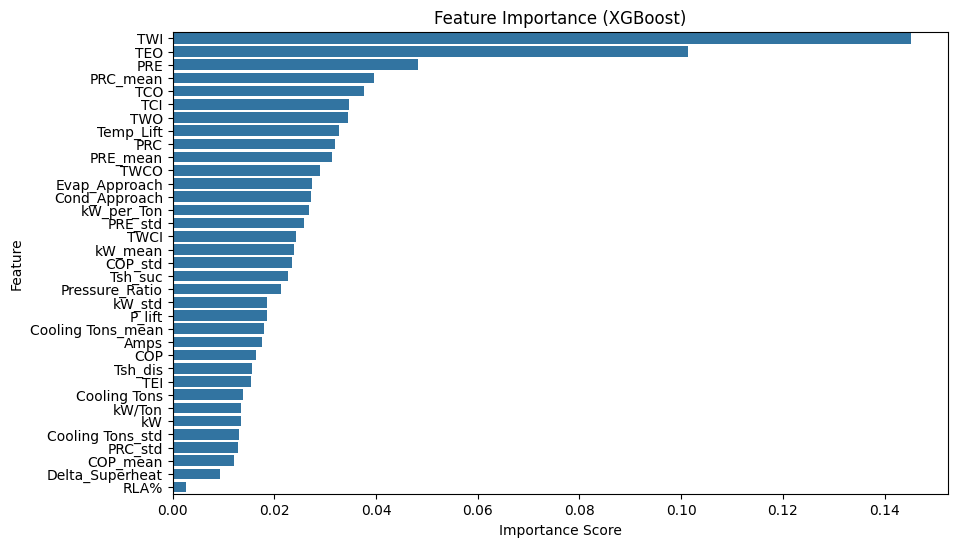

In [53]:
# Plot feature importance

importances = model.feature_importances_
feat_names = X.columns

sorted_idx = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
sns.barplot(x=importances[sorted_idx], y=feat_names[sorted_idx])
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")

plt.show()


## 5.Data visualization